In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_array, check_is_fitted

import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import inspect
import random
import shutil

from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy import optimize
from sklearn import decomposition, cluster, model_selection, metrics
import sklearn

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import utils.dataset_utils as dataset
import utils.train_utils as train

In [2]:
def unit_vector_norm(X):
    X -= X.min() #remove noise offset
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [3]:
X = np.load("../data/HSI/Liver_map_150z25_60s_1TCPOBOP.npy", 'r')
Y = np.load("../data/HSI/Liver_map_150z25_60s_2TCPOBOP.npy", 'r')
Z = np.load("../data/HSI/Liver_map_150z25_60s_3OBOB.npy", 'r')
wavelength = np.load("../data/HSI/wavelength.npy", 'r')

shape_X = X.shape 
shape_Y = Y.shape 
shape_Z = Z.shape 

X = copy.copy(X.reshape(-1, X.shape[-1]))
Y = copy.copy(Y.reshape(-1, Y.shape[-1]))
Z = copy.copy(Z.reshape(-1, Z.shape[-1]))

In [4]:
class AutoEncoderConv(nn.Module):
    def __init__(self, n_components=10, d=1):
        super().__init__()
        h = 30
        self.encode = nn.Sequential( 
            nn.Dropout3d(0.25),
            nn.Flatten(),
            nn.Linear(1000, h),
            nn.ReLU(True),
            nn.Dropout3d(0.5),
            *((nn.Linear(h, h),
            nn.ReLU(True)) * (d-1)),
            nn.Linear(h, n_components)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(n_components, h),
            nn.ReLU(True),
            *((nn.Linear(h, h),
            nn.ReLU(True)) * (d-1)),            
            nn.Linear(h, 1000),
            View((-1,1,1,1,1000))
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))  
        

In [5]:
def MSE_loss(x, model):
    x_ = model(x)
    return ((x - x_)**2).mean(0).sum()

In [6]:
class ReferenceVectorClassifierAE(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = {}
        self.k_means_kwargs = {}
        self.ae_kwargs = {}        
        self.set_params(**kwargs)

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        
    def fit(self, x, **kwargs):
        self.set_params(**kwargs)
        X = unit_vector_norm(x)
        
        ###################### Autoencoder ################################
        self.model = AutoEncoderConv(**self.ae_kwargs).to(self.device)
        
        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters)        
        train_loader, test_loader = dataset.load_liver(X, self.kwargs['batch_size'])
        
        for epoch in range(self.kwargs['epochs']):
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch+1, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, train_loader, self.kwargs['loss_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            loss = train.test(self.model, test_loader, self.kwargs['loss_func'], self.device)
            print('Validation| bits: {:2.2f}'.format(loss), flush=True)    
          
        self.model.eval()
        with torch.no_grad():
            z = self.model.encode(dataset.load_liver_all(X).to(self.device)).cpu()
              
        ###################### clustering ################################
        self.clusters = cluster.KMeans(**self.k_means_kwargs).fit(z)
        self.clusters = self.clusters.labels_
        
        one_hot = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        one_hot[range(X.shape[0]), self.clusters] = 1

        ###################### reference spectra ################################
        self.reference_spectra_ = np.array([X[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])
        self.ref_org = np.array([x[one_hot[:,i],:].mean(axis=0) for i in range(self.kwargs['n_clusters'])])

        # Return the classifier
        return self

    def predict(self, X):
        """
        predict transforms the data into the reference space. Min weight should be 0 or higher then 'min_weight'
        The error is the NMSE, where the MSE is normalised by the signal strength. 
        error.shape = X.shape[0], so for each data point the error is calculated.
        """
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        X = unit_vector_norm(X)
        
        ###################### RCA ################################
        old_mask = np.zeros((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        mask = np.ones((X.shape[0], self.kwargs['n_clusters']), dtype=bool)
        while np.abs(old_mask ^ mask).sum():
            RCA_vector = np.array([optimize.nnls(self.reference_spectra_.T * mask[i], X[i,:])[0] for i in range(X.shape[0])])
            old_mask, mask = mask, (RCA_vector.T / RCA_vector.sum(axis=1)).T >= self.kwargs['min_weight']            
        
        return RCA_vector  
    
    def get_reference_vectors(self):
        return self.reference_spectra_

    def get_org_reference_vectors(self):
        return self.ref_org    
    
    def get_params(self, deep=False):
        return self.kwargs
    
    def set_params(self, **kwargs):
        self.kwargs.update(kwargs)
        self.k_means_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(cluster.KMeans).parameters.keys())})     
        self.ae_kwargs.update({k:v  for k,v in kwargs.items() if k in list(inspect.signature(AutoEncoderConv).parameters.keys())})     
        return self

In [7]:
def error_map(estimator, X, y=None):
    RCA = estimator.predict(X)
    ref_vec = estimator.get_reference_vectors()
    return ((RCA @ ref_vec - X)**2).mean(1)

def score_func(estimator, X, y=None):
    X = unit_vector_norm(X)
    return error_map(estimator, X).mean()

def print_mean_std(X):
    return f"{X.mean():<12.4e}{X.std():<12.4e}"

def cross_val_X_Y_Z(rvc, X, Y, Z):
    rvc.fit(np.concatenate((X, Y), axis=0))
    return score_func(rvc, Z)

In [8]:
kwargs = {'n_clusters': 3,
          'n_components': 5, #enough for PCA
          'min_weight': 0,
          'batch_size': 64,
          'cuda': True,
          'log_step': 10,
          'loss_func': MSE_loss,
          'epochs': 3,
          'd':1
         }

header = f"{'mean':12}{'std':12}"


In [9]:
rvc = ReferenceVectorClassifierAE(**kwargs)

repeat = 3
depths = [0,1,2] + list(range(3,16,2))
error = []
for d in depths:
    print('calculating for d: ',d)
    kwargs['d'] = d
    tmp = 0
    for _ in range(repeat):
        rvc.fit(X)
        tmp += score_func(rvc, X)
    error.append(tmp/repeat)

calculating for d:  0
--------------------------------------------------
Epoch   1/  3
  2020-05-26 15:15:32|     0/   52| bits: 22.32
  2020-05-26 15:15:32|    10/   52| bits: 13.20
  2020-05-26 15:15:32|    20/   52| bits: 8.13
  2020-05-26 15:15:32|    30/   52| bits: 5.15
  2020-05-26 15:15:32|    40/   52| bits: 3.25
  2020-05-26 15:15:32|    50/   52| bits: 1.94
Elapsed time: 0h 0m 2s
Validation| bits: 1.69
--------------------------------------------------
Epoch   2/  3
  2020-05-26 15:15:36|     0/   52| bits: 1.76
  2020-05-26 15:15:36|    10/   52| bits: 0.97
  2020-05-26 15:15:36|    20/   52| bits: 0.52
  2020-05-26 15:15:36|    30/   52| bits: 0.28
  2020-05-26 15:15:36|    40/   52| bits: 0.15
  2020-05-26 15:15:36|    50/   52| bits: 0.08
Elapsed time: 0h 0m 2s
Validation| bits: 0.07
--------------------------------------------------
Epoch   3/  3
  2020-05-26 15:15:40|     0/   52| bits: 0.08
  2020-05-26 15:15:40|    10/   52| bits: 0.05
  2020-05-26 15:15:40|    20/  

  2020-05-26 15:16:54|    40/   52| bits: 0.01
  2020-05-26 15:16:54|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-26 15:16:58|     0/   52| bits: 20.17
  2020-05-26 15:16:58|    10/   52| bits: 12.82
  2020-05-26 15:16:58|    20/   52| bits: 8.23
  2020-05-26 15:16:59|    30/   52| bits: 5.10
  2020-05-26 15:16:59|    40/   52| bits: 3.01
  2020-05-26 15:16:59|    50/   52| bits: 1.73
Elapsed time: 0h 0m 2s
Validation| bits: 1.43
--------------------------------------------------
Epoch   2/  3
  2020-05-26 15:17:02|     0/   52| bits: 1.52
  2020-05-26 15:17:02|    10/   52| bits: 0.83
  2020-05-26 15:17:02|    20/   52| bits: 0.43
  2020-05-26 15:17:02|    30/   52| bits: 0.23
  2020-05-26 15:17:03|    40/   52| bits: 0.12
  2020-05-26 15:17:03|    50/   52| bits: 0.07
Elapsed time: 0h 0m 2s
Validation| bits: 0.05
--------------------------------------------------
Epoch   3/  3
  2020-

  2020-05-26 15:18:20|    20/   52| bits: 0.04
  2020-05-26 15:18:20|    30/   52| bits: 0.03
  2020-05-26 15:18:20|    40/   52| bits: 0.02
  2020-05-26 15:18:20|    50/   52| bits: 0.02
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-26 15:18:24|     0/   52| bits: 22.28
  2020-05-26 15:18:24|    10/   52| bits: 12.44
  2020-05-26 15:18:24|    20/   52| bits: 7.14
  2020-05-26 15:18:24|    30/   52| bits: 4.14
  2020-05-26 15:18:24|    40/   52| bits: 2.31
  2020-05-26 15:18:25|    50/   52| bits: 1.21
Elapsed time: 0h 0m 2s
Validation| bits: 1.00
--------------------------------------------------
Epoch   2/  3
  2020-05-26 15:18:30|     0/   52| bits: 1.04
  2020-05-26 15:18:30|    10/   52| bits: 0.52
  2020-05-26 15:18:30|    20/   52| bits: 0.25
  2020-05-26 15:18:30|    30/   52| bits: 0.13
  2020-05-26 15:18:30|    40/   52| bits: 0.07
  2020-05-26 15:18:30|    50/   52| bits: 0.04
Elapsed time: 0h 0m 2s
V

  2020-05-26 15:19:50|     0/   52| bits: 0.05
  2020-05-26 15:19:50|    10/   52| bits: 0.03
  2020-05-26 15:19:50|    20/   52| bits: 0.03
  2020-05-26 15:19:50|    30/   52| bits: 0.02
  2020-05-26 15:19:50|    40/   52| bits: 0.02
  2020-05-26 15:19:50|    50/   52| bits: 0.02
Elapsed time: 0h 0m 3s
Validation| bits: 0.01
calculating for d:  11
--------------------------------------------------
Epoch   1/  3
  2020-05-26 15:19:57|     0/   52| bits: 26.68
  2020-05-26 15:19:57|    10/   52| bits: 13.85
  2020-05-26 15:19:57|    20/   52| bits: 8.36
  2020-05-26 15:19:58|    30/   52| bits: 4.80
  2020-05-26 15:19:58|    40/   52| bits: 2.82
  2020-05-26 15:19:58|    50/   52| bits: 1.56
Elapsed time: 0h 0m 3s
Validation| bits: 1.22
--------------------------------------------------
Epoch   2/  3
  2020-05-26 15:20:04|     0/   52| bits: 1.36
  2020-05-26 15:20:05|    10/   52| bits: 0.69
  2020-05-26 15:20:05|    20/   52| bits: 0.34
  2020-05-26 15:20:05|    30/   52| bits: 0.16
 

Elapsed time: 0h 0m 2s
Validation| bits: 0.03
--------------------------------------------------
Epoch   3/  3
  2020-05-26 15:21:27|     0/   52| bits: 0.03
  2020-05-26 15:21:27|    10/   52| bits: 0.02
  2020-05-26 15:21:27|    20/   52| bits: 0.02
  2020-05-26 15:21:27|    30/   52| bits: 0.01
  2020-05-26 15:21:27|    40/   52| bits: 0.01
  2020-05-26 15:21:27|    50/   52| bits: 0.01
Elapsed time: 0h 0m 2s
Validation| bits: 0.01
--------------------------------------------------
Epoch   1/  3
  2020-05-26 15:21:31|     0/   52| bits: 22.52
  2020-05-26 15:21:31|    10/   52| bits: 12.90
  2020-05-26 15:21:32|    20/   52| bits: 8.14
  2020-05-26 15:21:32|    30/   52| bits: 4.92
  2020-05-26 15:21:32|    40/   52| bits: 2.88
  2020-05-26 15:21:32|    50/   52| bits: 1.58
Elapsed time: 0h 0m 2s
Validation| bits: 1.30
--------------------------------------------------
Epoch   2/  3
  2020-05-26 15:21:35|     0/   52| bits: 1.42
  2020-05-26 15:21:35|    10/   52| bits: 0.72
  2020-

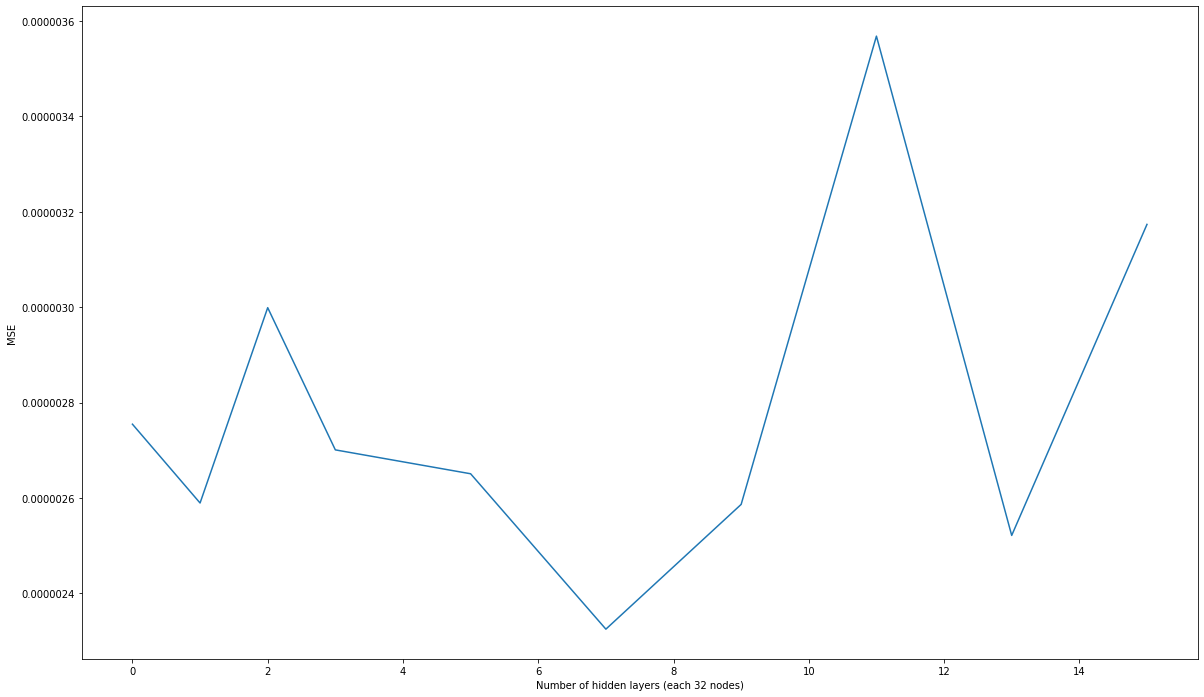

In [10]:
plt.figure(figsize = (20,12))
plt.plot(depths, error)
plt.ylabel('MSE')
plt.xlabel('Number of hidden layers (each 32 nodes)')
plt.show()